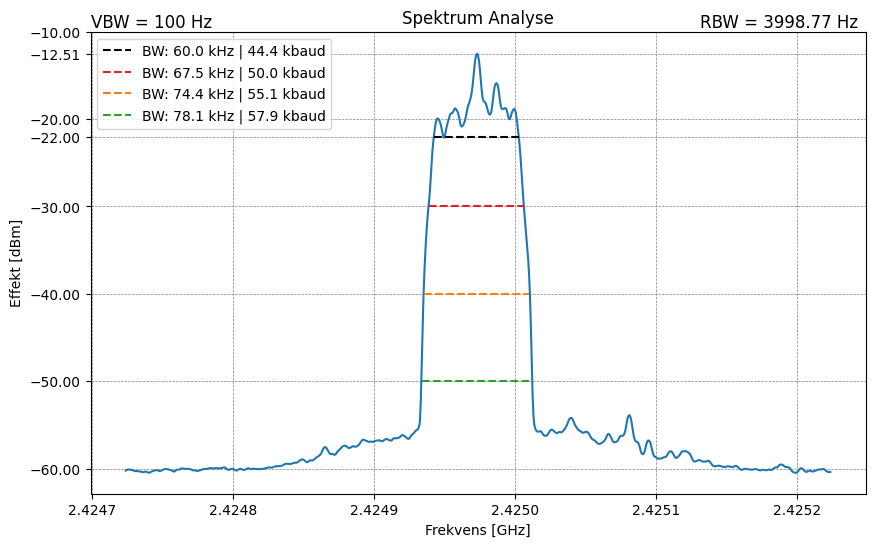

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path="Måling/spektrum30dBAttenuator56kBaud035RollOff.csv"
columns = ['Power [dBm]', 'Frequency[Hz]']
spektrum = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBm]'] = spektrum['Power [dBm]'] + 30 # Fjerne attenuatorens effekt

RBW= 3998.7715295257381 # Resolution Bandwidth in Hz
VBW = 100 # Video Bandwidth in Hz

# Calculate the bandwidth based on the thresholds
bw_thresholds = [-22,-30,-40,-50]
first_indecies = []
last_indecies = []

for bw_threshold in bw_thresholds:
    # Find first and last index where power is above bw_power
    first_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[0]
    last_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[-1]
    first_indecies.append(first_index)
    last_indecies.append(last_index)

# Calculate the bandwidths in kHz and baud rates
roll_off = 0.35 # Roll-off factor for the raised cosine filter
bandwidths = []
baud_rates = []
for first_index, last_index in zip(first_indecies, last_indecies):
    bandwidth = spektrum['Frequency[Hz]'][last_index] - spektrum['Frequency[Hz]'][first_index]
    bandwidths.append(bandwidth / 1000) # Convert to kHz
    baud_rates.append(bandwidth / (1 + roll_off) / 1000) # Assuming baud rate is half the bandwidth

def expected_spectrum_rrc(frequency, baud_rate, roll_off):
    """Calculate the expected spectrum for a raised cosine filter."""
    return 10 * np.log10(1 - (frequency / (baud_rate * (1 + roll_off)))**2)


bw_colors = ['k','tab:red', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBm]'], linestyle='-', color='tab:blue')

for i, (first_index, last_index,bw_threshold,bandwidth, baud_rate) in enumerate(zip(first_indecies, last_indecies,bw_thresholds,bandwidths,baud_rates)):
    plt.plot([spektrum['Frequency[GHz]'][first_index], spektrum['Frequency[GHz]'][last_index]],
             [bw_threshold, bw_threshold], linestyle='--', color=bw_colors[i], label=f'BW: {bandwidth:.1f} kHz | {baud_rate:.1f} kbaud')
plt.legend(loc='upper left')

plt.annotate('RBW = {:.2f} Hz'.format(RBW), xy=(0.99, 1.01), xycoords='axes fraction', fontsize=12, ha='right')
plt.annotate('VBW = {} Hz'.format(VBW), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

yticks = np.array([max(spektrum['Power [dBm]']),-22])
plt.yticks(np.append(np.arange(-60, 0, 10), yticks), fontsize=10)
plt.xlabel('Frekvens [GHz]')
plt.ylabel('Effekt [dBm]')
plt.title('Spektrum Analyse')
plt.show()

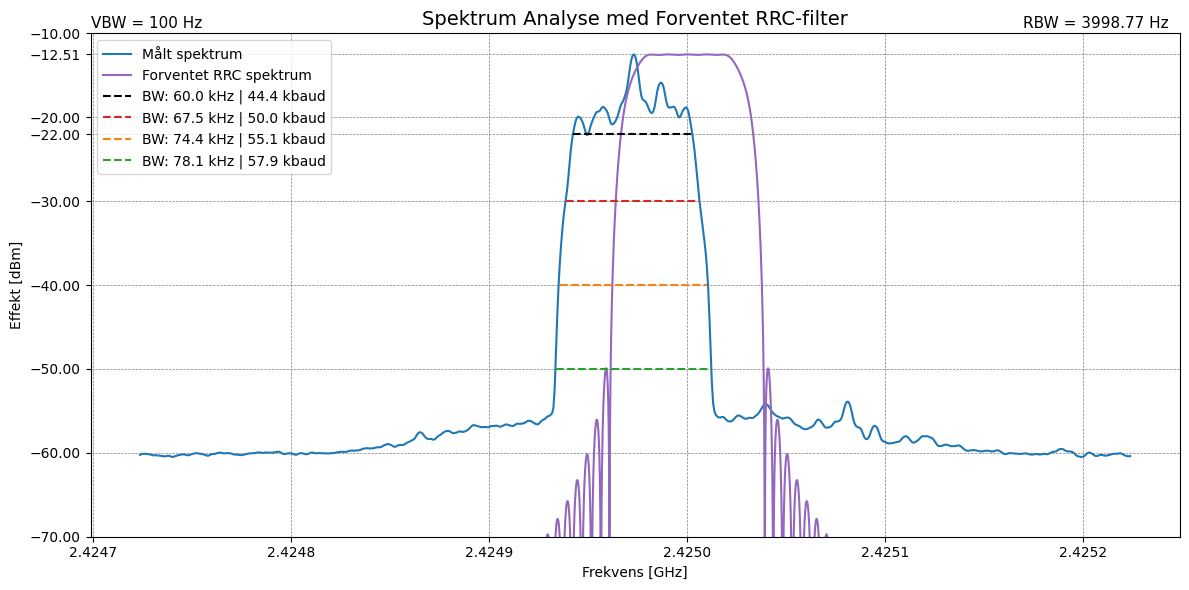

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import freqz

# === Lese måledata ===
file_path = "Måling/spektrum30dBAttenuator56kBaud035RollOff.csv"
columns = ['Power [dBm]', 'Frequency[Hz]']
spektrum = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBm]'] = spektrum['Power [dBm]'] + 30  # Kompensere for demping

RBW = 3998.77  # Hz
VBW = 100      # Hz

# === Beregn båndbredder ved ulike terskler ===
bw_thresholds = [-22, -30, -40, -50]
first_indecies = []
last_indecies = []

for bw_threshold in bw_thresholds:
    first_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[0]
    last_index = spektrum[spektrum['Power [dBm]'] >= bw_threshold].index[-1]
    first_indecies.append(first_index)
    last_indecies.append(last_index)

roll_off = 0.35
bandwidths = []
baud_rates = []
for first_index, last_index in zip(first_indecies, last_indecies):
    bandwidth = spektrum['Frequency[Hz]'][last_index] - spektrum['Frequency[Hz]'][first_index]
    bandwidths.append(bandwidth / 1000)  # kHz
    baud_rates.append(bandwidth / (1 + roll_off) / 1000)  # kbaud

# === RRC-filter: korrekt generering og FFT ===
def rrc_filter(beta, sps, N):
    T = 1
    t = np.arange(-N//2, N//2 + 1) / sps
    h = np.zeros_like(t)

    for i in range(len(t)):
        if t[i] == 0.0:
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif abs(t[i]) == T / (4 * beta):
            h[i] = (beta / np.sqrt(2)) * (
                (1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) +
                (1 - 2 / np.pi) * np.cos(np.pi / (4 * beta))
            )
        else:
            numerator = (
                np.sin(np.pi * t[i] * (1 - beta) / T) +
                4 * beta * t[i] * np.cos(np.pi * t[i] * (1 + beta) / T)
            )
            denominator = (
                np.pi * t[i] * (1 - (4 * beta * t[i] / T)**2)
            )
            h[i] = numerator / denominator
    return h

# === Parametre for RRC ===
symbol_rate = 56e3           # Baud
beta = 0.35                 # Roll-off
sps = 8                      # Samples per symbol
num_taps = 11*sps               # Filterlengde
lo_freq = 2.425e9              # Lokal oscillator frekvens i Hz

# === Lag filter og hent symmetrisk frekvensrespons ===
h_rrc = rrc_filter(beta, sps, num_taps)

# Bruk freqz for positiv frekvens
w_pos, h_pos = freqz(h_rrc, worN=2048, fs=sps * symbol_rate)

# Speil negativ del
w_neg = -np.flip(w_pos)
h_neg = np.flip(h_pos)

# Kombiner
w_full = np.concatenate((w_neg, w_pos))
h_full = np.concatenate((h_neg, h_pos))

# Shift til LO-frekvens
rrc_freqs = w_full + lo_freq
rrc_spec_db = 20 * np.log10(np.abs(h_full) + 1e-10)

# === Plotting ===
bw_colors = ['k', 'tab:red', 'tab:orange', 'tab:green']

plt.figure(figsize=(12, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBm]'],
         linestyle='-', color='tab:blue', label='Målt spektrum')

plt.plot(rrc_freqs / 1e9, rrc_spec_db + max(spektrum['Power [dBm]']) - np.max(rrc_spec_db),
         linestyle='-', color='tab:purple', label='Forventet RRC spektrum')

# Marker båndbredder
for i, (first_index, last_index, bw_threshold, bandwidth, baud_rate) in enumerate(zip(first_indecies, last_indecies, bw_thresholds, bandwidths, baud_rates)):
    plt.plot([spektrum['Frequency[GHz]'][first_index], spektrum['Frequency[GHz]'][last_index]],
             [bw_threshold, bw_threshold], linestyle='--', color=bw_colors[i],
             label=f'BW: {bandwidth:.1f} kHz | {baud_rate:.1f} kbaud')

plt.annotate(f'RBW = {RBW:.2f} Hz', xy=(0.99, 1.01), xycoords='axes fraction', fontsize=11, ha='right')
plt.annotate(f'VBW = {VBW} Hz', xy=(0, 1.01), xycoords='axes fraction', fontsize=11, ha='left')


plt.ylim(-70,-10)

plt.title('Spektrum Analyse med Forventet RRC-filter', fontsize=14)
plt.xlabel('Frekvens [GHz]')
plt.ylabel('Effekt [dBm]')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=10)
yticks = np.array([max(spektrum['Power [dBm]']), -22])
plt.yticks(np.append(np.arange(-70, 0, 10), yticks), fontsize=10)
plt.tight_layout()
plt.show()